In [8]:
import matplotlib.pyplot as plt  # matplotlib for some plotting
import numpy as np  # numeric python functions
import pandas as pd  # need this to load our data from the csv files

from pyconturb import gen_turb, gen_spat_grid, TimeConstraint  # generate turbulence, useful helper
from pyconturb.sig_models import iec_sig  # IEC 61400-1 turbulence std dev
from pyconturb.spectral_models import kaimal_spectrum  # Kaimal spectrum
from pyconturb.wind_profiles import constant_profile, power_profile  # wind-speed profile functions

from _nb_utils import plot_slice
import h5py

## Constrained Turbulence ##
copied from [PyConTurb example](https://pyconturb.pages.windenergy.dtu.dk/pyconturb/notebooks/3_constr_time_series.html)

### Step 1: generate dataframe of measurement data ###

In [9]:
# sonic position
x_sonic1 = 0.0
y_sonic1 = 0.0
z_sonic1 = 2.23 # m above ground

sonic_spat_df = gen_spat_grid(y_sonic1, z_sonic1)  # if `comps` not passed in, assumes all 3 components are wanted
sonic_spat_df.head()  # look at the first few rows

,u_p0,v_p0,w_p0
k,0.00,1.00,2.00
x,0.00,0.00,0.00
y,0.00,0.00,0.00
z,2.23,2.23,2.23


In [10]:
# m2 tower data
m2 = {}
m2['u'] = [9.3218, 10.212, 11.211]
m2['z'] = [2, 5, 10]
m2['w_dir'] = [282.07, 275.67, 275.35]
m2['Iu'] = [0.1542, 0.149, 0.1455]

In [11]:
# def read_csv_data(sonic_data_fn, dt_sonic1):
def read_csv_data(raw_data):
    # read csv
    # raw_data = pd.read_csv(sonic_data_fn, header=None)

    # select only sonic data columns
    sonic_data = raw_data[['u (m/s)', 'v (m/s)', 'w (m/s)']]

    # downsample from 50 Hz to 4 Hz (sonic resolution)
    # sonic_data = sonic_data.resample('250ms').median() # 4 Hz = 250 milliseconds

    # construct time index
    tmp = (sonic_data.index[1]-sonic_data.index[0])
    dt_sonic1 = round(tmp.total_seconds(), 3)
    # print(dt_sonic1)
    tf_sonic1 = len(sonic_data) * dt_sonic1 # final time [s]
    # print(tf_sonic1)
    t_sonic1 = np.arange(0.0, tf_sonic1, dt_sonic1)

    sonic_data = sonic_data.rename(columns={'u (m/s)':'u_p0', 'v (m/s)':'v_p0', 'w (m/s)':'w_p0'})
    for col in sonic_data.filter(regex='u_', axis=1).columns:
        sonic_data[col] = -1.0*sonic_data[col] # to make it positive from the west
    sonic_data['index'] = t_sonic1
    sonic_data = sonic_data.set_index('index')

    return tf_sonic1, sonic_data

# sonic_data_fn = 'sonic1_halfsecond_20Hz.csv'
# sonic_data_fn = 'sonic1_5s_20Hz.csv'
# sonic_data_fn = 'sonic1_20s_20Hz.csv'
# sonic_data_fn = 'sonic1_10min_20Hz.csv'
# sonic_data_fn = 'sonic1_10min_50Hz.csv'
sonic_data_fn = 'DuraMAT_tilt40deg_turbulent_inflow_10min_timeseries.csv'

raw_data = pd.read_csv(sonic_data_fn, index_col='Time')
raw_data.index = pd.to_datetime(raw_data.index)
# raw_data

# tmp = (raw_data.index[1]-raw_data.index[0])
# dt_sonic1 = round(tmp.total_seconds(), 3)

tf_sonic1, sonic_data = read_csv_data(raw_data)
dt = sonic_data.index[1]-sonic_data.index[0]
sonic_data

,u_p0,v_p0,w_p0
index,,,
0.00,9.541354,0.007880,0.718606
0.02,9.540954,0.008039,0.718082
0.04,9.540588,0.007120,0.718604
0.06,9.541167,0.005969,0.718446
0.08,9.541007,0.005632,0.718398
...,...,...,...
599.90,14.001130,2.163276,-0.917014
599.92,14.000917,2.163653,-0.916638
599.94,14.000855,2.163678,-0.916363


Text(0.5, 0, 'time')

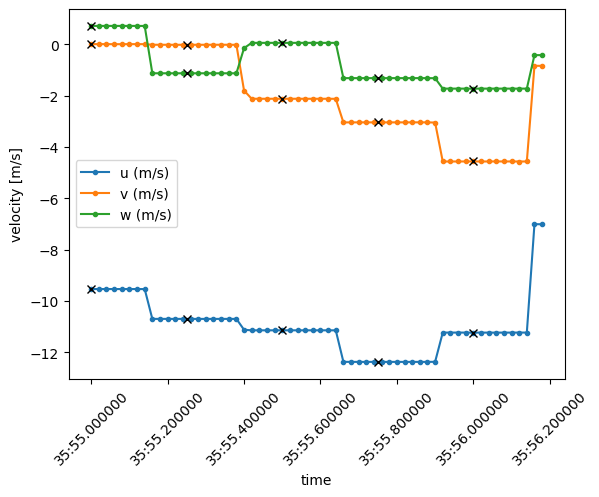

In [12]:
vel_cols = ['u (m/s)', 'v (m/s)', 'w (m/s)']
plt_data = raw_data.iloc[:60]
fig, axs = plt.subplots()
for col in vel_cols:
    plt.plot(plt_data[col], '.-', label=col)  # subselect long. wind component
    # plt.plot(plt_data[col].resample('50ms').median(), 'kx', label=col)  # subselect long. wind component
    plt.plot(plt_data[col].resample('250ms').median(), 'kx')  # subselect long. wind component
axs.set_ylabel('velocity [m/s]');
axs.legend()
axs.tick_params(axis='x', rotation=45)
axs.set_xlabel('time')

In [13]:
# # sanity check 50 Hz data with 20 Hz data
# sonic_data_fns = ['sonic1_10min_20Hz.csv','sonic1_10min_50Hz.csv']

# fig, ax = plt.subplots(figsize=[12,3])
# for fn in sonic_data_fns:
#     dt_check = 1.0/int(fn[13:15])
#     # print(dt_check)
#     tf_check, sonic_data_check = read_csv_data(fn, dt_check)
#     print(len(sonic_data_check))

#     sonic_data_check = sonic_data_check.loc[sonic_data_check.index <= 5.0]

#     t = sonic_data_check.index.values
#     print(t[:10])

#     ax.plot(t,sonic_data_check.filter(regex='u'),'.-',markersize=4,label = fn[13:15]+' Hz')
#     ax.legend()
#     ax.set_ylabel('velocity [m/s]')
#     ax.set_xlabel('time [s]')

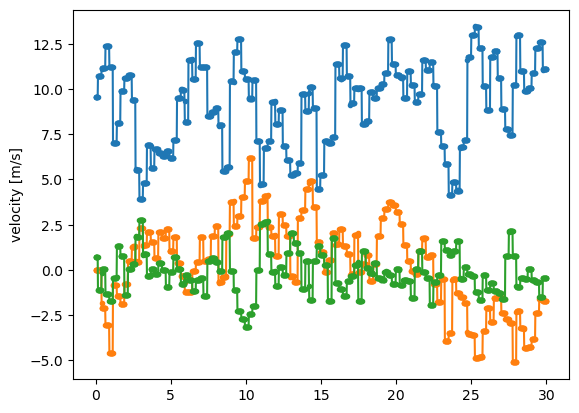

In [14]:
# optional: cut down duration of signal for testing
tf_sonic1 = 30.0 # [s] - this is also how long the synthetic turbulence signal will be
sonic_data = sonic_data.loc[sonic_data.index <= tf_sonic1]

fig, axs = plt.subplots()
for col in sonic_data.columns:
    plt.plot(sonic_data[col], marker='.', label=col)  # subselect long. wind component
    # plt.plot(sonic_data[col].resample('50L').first(), marker='.', label=col)  # subselect long. wind component
axs.set_ylabel('velocity [m/s]');

sonic_df = pd.concat([sonic_spat_df, sonic_data], axis=0)
# sonic_df.head()

In [ ]:
gen_csv_fname = 'generated_{}_{}s_{}Hz.csv'.format(sonic_data_fn[:34],int(tf_sonic1),int(1/dt))
sonic_df.to_csv(gen_csv_fname)

### Step 2: read in csv of measurement data ###

In [16]:
con_tc = TimeConstraint(pd.read_csv(gen_csv_fname, index_col=0))  # load data from csv directly into tc
# con_tc = TimeConstraint(pd.read_csv('generated_sonic1_1s.csv', index_col=0))  # load data from csv directly into tc
con_tc.index = con_tc.index.map(lambda x: float(x) if (x not in 'kxyz') else x)  # index cleaning
con_tc.iloc[:7, :]  # look at the first 7 rows

time_df = con_tc.get_time()

# for var in ['u_','v_','w_']:
#     ax = time_df.filter(regex=var, axis=1).plot(lw=0.75)  # subselect long. wind component
#     ax.set_ylabel(var + ' [m/s]');

[print(x) for x in time_df.filter(regex='u_', axis=1).mean()];  # print mean values
u_mean_sonic1 = time_df.filter(regex='u_', axis=1).mean()

9.102151923850766


### Step 3: generate constrained turbulence box ###

In [50]:
# define spatial information
# y = np.linspace(-5, 5, 7) #11) #22)  # 11 lateral points from -50 to 50 (center @ 0)
# z = np.linspace(0.5, 10.5, 13) #13) # 26)  # 13 vertical points from 40 to 160 (center @ 100)

# to match pvade sim
ny = 300 # 130 #41
# nz = 60 #130 #20
# y = np.linspace(-10.0, 10.0, ny) #11) #22)  # 11 lateral points from -50 to 50 (center @ 0)
y = np.linspace(-30.0, 30.0, ny) #11) #22)  # 11 lateral points from -50 to 50 (center @ 0)
# z = np.linspace(0.00001, 20.0, nz) #13) # 26)  # 13 vertical points from 40 to 160 (center @ 100)
# z = np.logspace(-5, 1.301, num=nz) #13) # 26)  # 13 vertical points from 40 to 160 (center @ 100)
# linearly increasing grid size in z
steps = 0.15 + 0.02 * np.arange(60)
z = 0.0001 + np.cumsum(steps)
z = z[z <= 20.0]
nz = len(z)

dy = y[1] - y[0] # (y[-1]-y[0])/ny
dz = z[1] - z[0] # (z[-1]-z[0])/nz

# this resolution should be approximately equal to or smaller than l_char
print(f'dy = {dy:.3f} m, dz = {dz:.5f} m')

spat_df = gen_spat_grid(y, z)  # if `comps` not passed in, assumes all 3 components are wanted
spat_df.head()  # look at the first few rows

dy = 0.201 m, dz = 0.17000 m


,u_p0,v_p0,w_p0,u_p1,v_p1,w_p1,u_p2,v_p2,w_p2,u_p3,...,w_p11396,u_p11397,v_p11397,w_p11397,u_p11398,v_p11398,w_p11398,u_p11399,v_p11399,w_p11399
k,0.0000,1.0000,2.0000,0.0000,1.0000,2.0000,0.0000,1.0000,2.0000,0.0000,...,2.0000,0.0000,1.0000,2.0000,0.0000,1.0000,2.0000,0.0000,1.0000,2.0000
x,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
y,-30.0000,-30.0000,-30.0000,-30.0000,-30.0000,-30.0000,-30.0000,-30.0000,-30.0000,-30.0000,...,30.0000,30.0000,30.0000,30.0000,30.0000,30.0000,30.0000,30.0000,30.0000,30.0000
z,0.1501,0.1501,0.1501,0.3201,0.3201,0.3201,0.5101,0.5101,0.5101,0.7201,...,17.1501,18.0001,18.0001,18.0001,18.8701,18.8701,18.8701,19.7601,19.7601,19.7601


(0.0, 25.0)

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


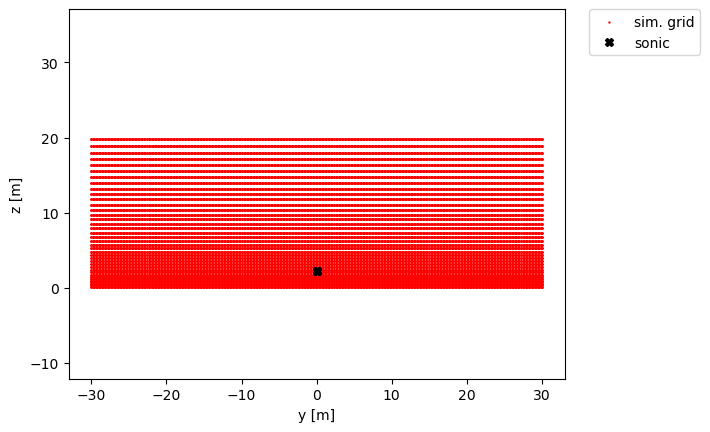

In [ ]:
# visualization of simulation grid and constraining point(s)   
plt.scatter(spat_df.loc['y'], spat_df.loc['z'], color='r', s=0.5, label='sim. grid')
plt.plot(con_tc.iloc[2, :6], con_tc.iloc[3, :6], 'kX', label='sonic')
plt.xlabel('y [m]')
plt.ylabel('z [m]')
plt.axis('equal'); plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
# plt.xlim([-3, 3])
# plt.ylim([0, 5])

In [19]:
# powerlaw_prof = power_profile(spat_df, u_ref=u_mean_sonic1.values[0], z_ref=2.23, alpha=0.2)
# powerlaw_prof

Text(0, 0.5, 'height [m]')

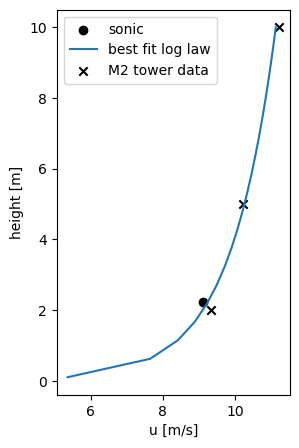

In [53]:
# log law profile at flatirons - to approximate u_ref input to gen_turb

z_log = np.linspace(0.1, 10, 20)
u_log = (0.5/0.4)*np.log(z_log/0.05)+4.5 # to match M2 tower data
# u_log = (0.55/0.4)*np.log(z_log/0.05)+4.5 # to match sonic data

y_idx = (np.abs(y - 0.0)).argmin()
u_inp = {}
u_inp['sonic'] = sonic_data.filter(regex='u_', axis=1).values.squeeze()

fig, axs = plt.subplots(figsize=[3,5])
axs.scatter(u_inp['sonic'].mean(), z_sonic1, color='k', label='sonic')
# axs[0].scatter(u_inp['sim'].mean(axis=0), z_fp, color='r', label='sim')
axs.plot(u_log, z_log, label='best fit log law')
axs.scatter(m2['u'], m2['z'], color='k', marker='x', label='M2 tower data')
axs.legend();
axs.set_xlabel('u [m/s]')
axs.set_ylabel('height [m]')
# print('u_max = ',u_inp['sim'].mean(axis=0).max())

In [24]:
from scipy import interpolate

# create function for funding u_ref at z_hub = 10 according to log law at flatirons
def find_u_ref(z_hub):
    z_log = np.linspace(0.1, 10, 20)
    u_log = (0.5/0.4)*np.log(z_log/0.05)+4.5 # to match M2 tower data
    # u_log = (0.55/0.4)*np.log(z_log/0.05)+4.5 # to match sonic data
    # u_log = (0.6/0.4)*np.log(z_log/0.05)+5.5 # to match sonic data
    f = interpolate.interp1d(z_log, u_log)

    u_ref = f(z_hub)

    return u_ref

In [25]:
# define paramters for turbulence generation technique
# this example uses the default IEC 61400-1 Ed. 3 (Kaimal Spectrum with Exponential Coherence)
# instead of interpolating from the data

z_hub = 10
u_ref = find_u_ref(z_hub) * 1.75
print('u_ref = ', u_ref)

# for 10-sec time period
# kwargs = {'u_ref': u_mean_sonic1.values[0], 'turb_class': 'B', 'z_hub': z_sonic1,  # necessary keyword arguments for IEC turbulence
#           'T': con_tc.get_T(), 'nt': con_tc.get_time().index.size}  # simulation length (s) and time step (s)
# interp_data = 'none' # 'all'  # use the default IEC 61400-1 profile instead of interpolating from contstraints
# kwargs = {'u_ref': 18.5, 'turb_class': 'B', 'z_hub': 10,  # necessary keyword arguments for IEC turbulence
#           'T': con_tc.get_T(), 'nt': con_tc.get_time().index.size}  # simulation length (s) and time step (s)
# interp_data = 'none' # 'all'  # use the default IEC 61400-1 profile instead of interpolating from contstraints
kwargs = {'u_ref': u_ref, 'turb_class': 'B', 'z_hub': z_hub,  # necessary keyword arguments for IEC turbulence
          'T': con_tc.get_T(), 'nt': con_tc.get_time().index.size}  # simulation length (s) and time step (s)
interp_data = 'none' # 'all'  # use the default IEC 61400-1 profile instead of interpolating from constraints

# for 10-min time period
# kwargs = {'u_ref': 21.0, 'turb_class': 'B', 'z_hub': 10,  # necessary keyword arguments for IEC turbulence
#           'T': con_tc.get_T(), 'nt': con_tc.get_time().index.size}  # simulation length (s) and time step (s)
# interp_data = 'none' # 'all'  # use the default IEC 61400-1 profile instead of interpolating from contstraints

# generate turbulence
sim_turb_df = gen_turb(spat_df, con_tc=con_tc, interp_data=interp_data, verbose=True, **kwargs)

u_ref =  19.46506923932383
Beginning turbulence simulation...
  Processing chunk 2 / 751
  Processing chunk 3 / 751
  Processing chunk 4 / 751
  Processing chunk 5 / 751
  Processing chunk 6 / 751
  Processing chunk 7 / 751
  Processing chunk 8 / 751
  Processing chunk 9 / 751
  Processing chunk 10 / 751
  Processing chunk 11 / 751
  Processing chunk 12 / 751
  Processing chunk 13 / 751
  Processing chunk 14 / 751
  Processing chunk 15 / 751
  Processing chunk 16 / 751
  Processing chunk 17 / 751
  Processing chunk 18 / 751
  Processing chunk 19 / 751
  Processing chunk 20 / 751
  Processing chunk 21 / 751
  Processing chunk 22 / 751
  Processing chunk 23 / 751
  Processing chunk 24 / 751
  Processing chunk 25 / 751
  Processing chunk 26 / 751
  Processing chunk 27 / 751
  Processing chunk 28 / 751
  Processing chunk 29 / 751
  Processing chunk 30 / 751
  Processing chunk 31 / 751
  Processing chunk 32 / 751
  Processing chunk 33 / 751
  Processing chunk 34 / 751
  Processing chunk 35 

In [26]:
# save to csv file
# sim_turb_fname = 'constrained_turb_ny{}_nz{}_sonic1_{}s{}'.format(ny,nz,int(tf_sonic1),sonic_data_fn[-9:])
sim_turb_fname = f'constrained_turb_ny{ny}_nz{nz}_sonic1_{int(tf_sonic1)}s_u{round(u_mean_sonic1.values[0],3)}_{int(1/dt)}Hz.csv'
# sim_turb_df.to_csv('constrained_turb_'+sonic_data_fn)
sim_turb_df.to_csv(sim_turb_fname)

In [27]:
# reshape to 3D array
data = {}
data['u'] = sim_turb_df.filter(regex='u').values.reshape(len(sim_turb_df),y.size,z.size).transpose((0, 2, 1))
data['v'] = sim_turb_df.filter(regex='v').values.reshape(len(sim_turb_df),y.size,z.size).transpose((0, 2, 1))
data['w'] = sim_turb_df.filter(regex='w').values.reshape(len(sim_turb_df),y.size,z.size).transpose((0, 2, 1))

comparing timeseries at (y,z) = (-0.10,2.07)
measured mean wind speed =  9.102151923850766
simulated mean wind speed =  9.153890563994198
percent error = 0.57%


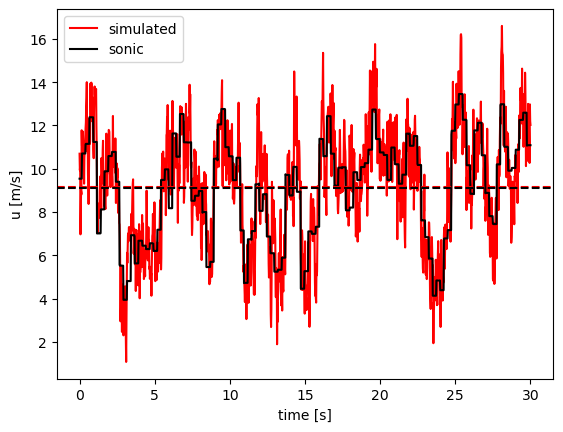

In [28]:
yloc, zloc = 0, 2.23  # location we want to compare

j = np.argmin(abs(y - yloc))
k = np.argmin(abs(z - zloc))

print('comparing timeseries at (y,z) = ({:.2f},{:.2f})'.format(y[j],z[k]))

usim = data['u'][:,k,j]
ucon = con_tc.get_time()['u_p0']

t = sim_turb_df.index
plt.plot(t, usim, label='simulated', color='r')
plt.plot(t, ucon, label='sonic', color='k')
plt.axhline(np.average(usim), t[0], t[-1], linestyle='--', color='r')
plt.axhline(np.average(ucon), t[0], t[-1], linestyle='--', color='k')
plt.xlabel('time [s]')
plt.ylabel('u [m/s]')
plt.legend();

measured_mean = np.average(ucon)
simulated_mean = np.average(usim)
print('measured mean wind speed = ', measured_mean)
print('simulated mean wind speed = ', simulated_mean)
print('percent error = {:.2f}%'.format(100*(simulated_mean - measured_mean) / measured_mean))

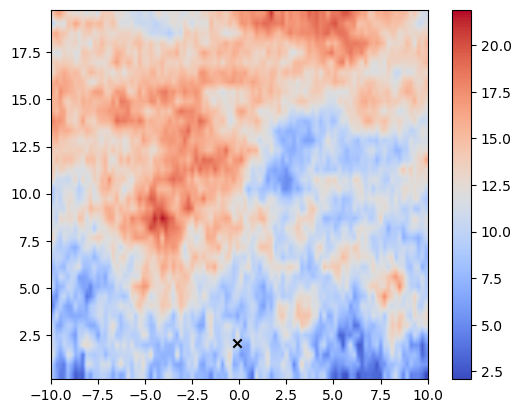

In [29]:
# check position
fig, ax = plt.subplots()
plt.imshow(data['u'][0,:,:],  # imshow requires nz-ny slice
            origin='lower',  # smallest y-z in lower left, not upper left
            extent=[y[0], y[-1], z[0], z[-1]],  # lateral and vertical limits
            interpolation='bilinear',
            cmap='coolwarm')  # image smoothing
plt.colorbar()
plt.scatter(y[j], z[k], c='k', marker='x')

In [30]:
# visualization of flow field
# fig, ax = plt.subplots()
# plt.imshow(data['u'][0,:,:],  # imshow requires nz-ny slice
#             origin='lower',  # smallest y-z in lower left, not upper left
#             extent=[y[0], y[-1], z[0], z[-1]],  # lateral and vertical limits
#             interpolation='none')  # image smoothing
# plt.colorbar()
# plt.title('first timestep')

# fig, ax = plt.subplots()
# plt.imshow(data['u'][-1,:,:],  # imshow requires nz-ny slice
#             origin='lower',  # smallest y-z in lower left, not upper left
#             extent=[y[0], y[-1], z[0], z[-1]],  # lateral and vertical limits
#             interpolation='none')  # image smoothing
# plt.colorbar()
# plt.title('last timestep')


### Step 4: Save generated turbulence as .h5 file for input to PVade ###

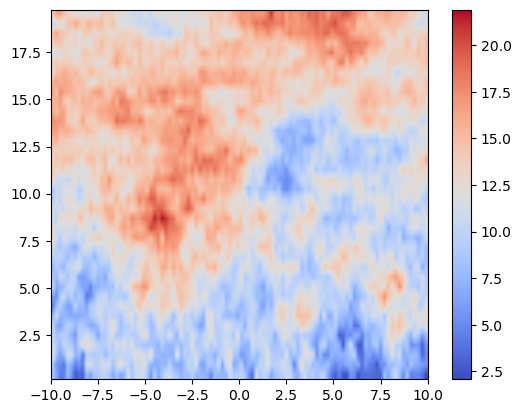

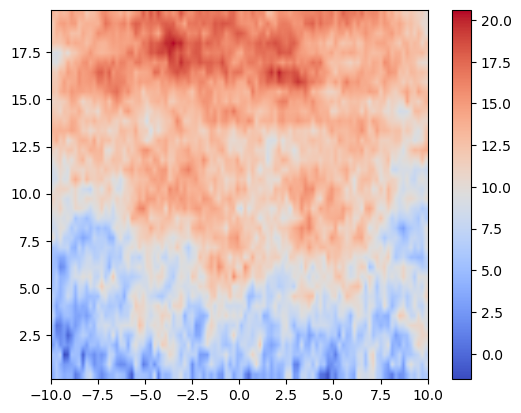

In [32]:
fig, ax = plt.subplots()
plt.imshow(data['u'][0,:,:],  # imshow requires nz-ny slice
            origin='lower',  # smallest y-z in lower left, not upper left
            extent=[y[0], y[-1], z[0], z[-1]],  # lateral and vertical limits
            interpolation='bilinear',
            cmap='coolwarm')  # image smoothing
plt.colorbar()

fig, ax = plt.subplots()
plt.imshow(data['u'][100,:,:],  # imshow requires nz-ny slice
            origin='lower',  # smallest y-z in lower left, not upper left
            extent=[y[0], y[-1], z[0], z[-1]],  # lateral and vertical limits
            interpolation='bilinear',
            cmap='coolwarm')  # image smoothing
plt.colorbar()

In [33]:
# # h5_filename = 'pct_turb_'+sonic_data_fn[:-4]+'.h5'
# h5_filename = 'pct_turb_ny80_nz40_sonic1_1s.h5'
h5_filename = f'pct_{sim_turb_fname[:-4]}.h5'
h5_filename

'pct_constrained_turb_ny100_nz38_sonic1_30s_u9.102_50Hz.h5'

time_index (1501,) float32
u (1501, 38, 100) float32
v (1501, 38, 100) float32
w (1501, 38, 100) float32
y_coordinates (100,) float32
z_coordinates (38,) float32


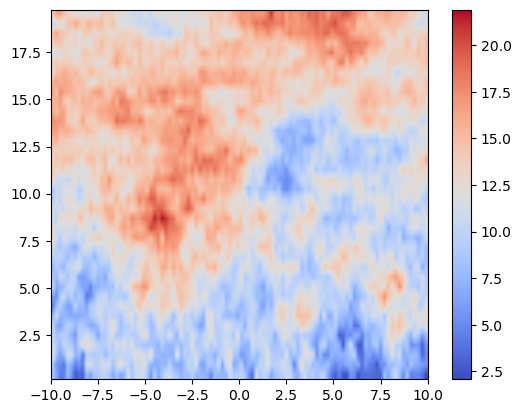

In [34]:
# h5_filename = 'pct_turb_'+sonic_data_fn[:-4]+'.h5'
t_steps = con_tc.get_time().index.size
time = con_tc.get_time().index.values.astype(float)

with h5py.File(h5_filename, "w") as fp:
    fp.create_dataset("time_index", shape=(t_steps,))
    fp["time_index"][:] = time
    
    fp.create_dataset("y_coordinates", shape=(ny,))
    fp["y_coordinates"][:] = y
        
    fp.create_dataset("z_coordinates", shape=(nz,))
    fp["z_coordinates"][:] = z
        
    fp.create_dataset("u", shape=(t_steps, nz, ny))
    fp["u"][:] = data['u'][:]
    
    fp.create_dataset("v", shape=(t_steps, nz, ny))
    fp["v"][:] = data['v'][:]
    
    fp.create_dataset("w", shape=(t_steps, nz, ny))
    fp["w"][:] = data['w'][:]

with h5py.File(h5_filename, "r") as fp:
    for key, val in fp.items():
        print(key, val.shape, val.dtype)
        
    y_fp = fp["y_coordinates"][:]
    z_fp = fp["z_coordinates"][:]

    fig, ax = plt.subplots()
    plt.imshow(fp["u"][0, :, :],  # imshow requires nz-ny slice
                origin='lower',  # smallest y-z in lower left, not upper left
                extent=[y_fp[0], y_fp[-1], z_fp[0], z_fp[-1]],  # lateral and vertical limits
                interpolation='bilinear',
                cmap='coolwarm')  # image smoothing
    plt.colorbar()

### Step 6: Compare metrics of simulated turbulence to measurement data ###

In [35]:
h5_filename

'pct_constrained_turb_ny100_nz38_sonic1_30s_u9.102_50Hz.h5'

time_index (1501,) float32
u (1501, 38, 100) float32
v (1501, 38, 100) float32
w (1501, 38, 100) float32
y_coordinates (100,) float32
z_coordinates (38,) float32


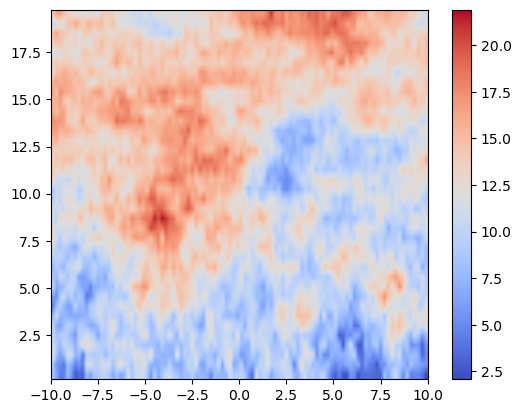

In [36]:
# read in simulated turbulence data
# h5_filename = 'pct_turb_'+sonic_data_fn[:-4]+'.h5'
# h5_filename = 'pct_turb_ny80_nz40_unconstrained_1s_dt01.h5'
# h5_filename = 'pct_turb_ny80_nz40_unconstrained_1s_dt01_uref20.h5'
# h5_filename = 'pct_turb_ny80_nz40_sonic1_1s.h5'
# h5_filename = 'pct_constrained_turb_ny100_nz38_sonic1_60s_u9.857.h5'
sim_data = {}

with h5py.File(h5_filename, "r") as fp:
    for key, val in fp.items():
        print(key, val.shape, val.dtype)
        
    y_fp = fp["y_coordinates"][:]
    z_fp = fp["z_coordinates"][:]

    fig, ax = plt.subplots()
    plt.imshow(fp["u"][0, :, :],  # imshow requires nz-ny slice
                origin='lower',  # smallest y-z in lower left, not upper left
                extent=[y_fp[0], y_fp[-1], z_fp[0], z_fp[-1]],  # lateral and vertical limits
                interpolation='bilinear',
                cmap='coolwarm')  # image smoothing
    plt.colorbar()

    sim_data["u"] = fp["u"][:, :, :]
    sim_data["v"] = fp["v"][:, :, :]
    sim_data["w"] = fp["w"][:, :, :]

(0.01, 1.0)

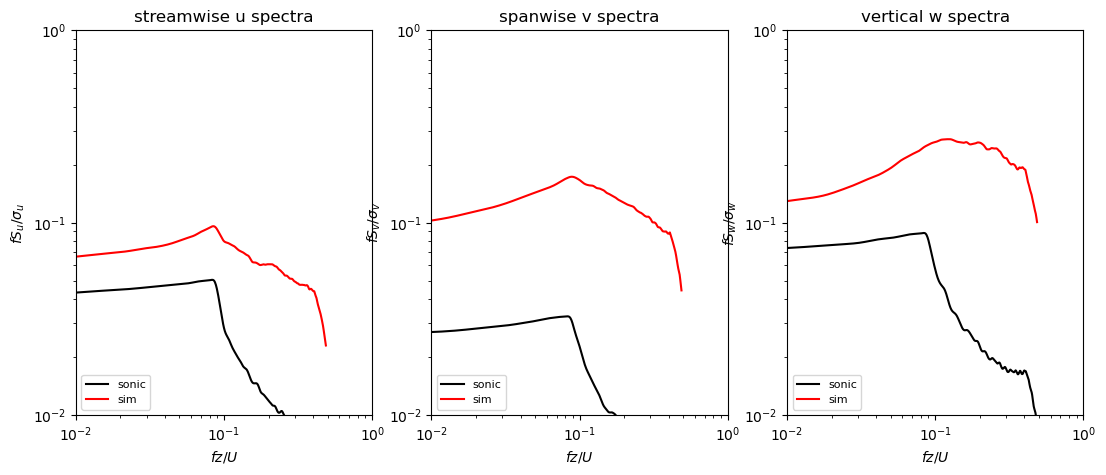

In [49]:
# spectra
from scipy.signal import welch
from numpy import hanning
import math

# Smooth high frequency region
def runningMeanFast(x, N):
    """
    Calculates the running mean of an array x over a window size N.

    Returns:
        np.ndarray: Smoothed signal
    """
    return np.convolve(x, np.ones(N)/N, mode='same') 

def compute_spectra(u, U_mean, height, fs, overlap):
    """
    Computes the normalized energy spectrum of a velocity time series `u`,
    smooths the high-frequency tail, and returns the normalized frequency
    and smoothed normalized power spectral density.

    Parameters:
        u (array-like): Time series of velocity fluctuations (1D)
        U_mean (float): Mean flow velocity (for normalization)
        height (float): Reference height (for normalization)
        fs (float): Sampling frequency [Hz]
        overlap (int): Number of samples to overlap in Welch’s method

    Returns:
        nf_U_corr (np.ndarray): Normalized frequency array
        nPxxf_mod_U_corr (list of np.ndarray): Concatenated original and smoothed
            normalized power spectral density
    """

    # Length of the input time series (used for FFT size and window)
    nblock = len(u)

    # Use a Hamming window for spectral estimation
    win = np.hamming(math.floor(nblock/10))

    # Convert u to a pandas Series for easier handling (e.g., dropna, stats)
    U_corr = pd.Series(u)
    # do I need to detrend this? - probably not bc of "detrend = constant" in welch function call

    # Standard deviation of the fluctuations (used to normalize PSD)
    u_std = U_corr.std()

    # Compute power spectral density using Welch's method
    f_U_corr, Pxxf_U_corr = welch(U_corr.dropna(), fs, window=win, noverlap=overlap, nfft=nblock, detrend='constant', return_onesided=True) # detrend constant removes mean (zero-mean segments)
    
    # Normalize frequency: non-dimensional frequency = f * z / U_mean
    nf_U_corr = f_U_corr*height/abs(U_mean)

    # Normalize power: dimensionless spectral density
    nPxxf_U_corr = (f_U_corr*Pxxf_U_corr)/u_std**2

    # Identify index where normalized frequency > 0.3 (start smoothing here)
    index_highfreq_U_corr = list(np.where([abs(nf_U_corr)>0.3]))

    # Extract the high-frequency tail to smooth
    nPxxf_smooth_U_corr = nPxxf_U_corr[index_highfreq_U_corr[0][0]:len(nPxxf_U_corr)]

    # Apply running mean to smooth the high-frequency region
    avg_window_size = int(nblock/6)
    nPxxf_smooth_U_corr = runningMeanFast(nPxxf_smooth_U_corr,avg_window_size) # 200)

    # Concatenate the low-frequency part (unsmoothed) with the smoothed tail
    nPxxf_mod_U_corr = [nPxxf_U_corr[0:index_highfreq_U_corr[0][0]-1],nPxxf_smooth_U_corr]
    # nPxxf_mod_U_corr = nPxxf_U_corr # without smoothing

    # return nf_U_corr, nPxxf_mod_U_corr
    return nf_U_corr, nPxxf_mod_U_corr

heights = [2.23] # [10.0] # [2.23] 
# fs = {'sonic': 4, 'sim': 50}
fs = {'sonic': 4, 'sim': 4}
overlap = 0

z_idx = (np.abs(z_fp - heights[0])).argmin() # same height as sonic
y_idx = (np.abs(y_fp - 0.0)).argmin()

vars = ['sonic','sim']
colors = {'sonic': 'k', 'sim': 'r'}
nf_U_corr = {}; nPxxf_mod_U_corr = {}
nf_V_corr = {}; nPxxf_mod_V_corr = {}
nf_W_corr = {}; nPxxf_mod_W_corr = {}
u_inp = {}; v_inp = {}; w_inp = {}
U_mean = {}

u_inp['sonic'] = sonic_data.filter(regex='u_', axis=1).values.squeeze()
u_inp['sim'] = sim_data['u'][:,z_idx,y_idx]
v_inp['sonic'] = sonic_data.filter(regex='v_', axis=1).values.squeeze()
v_inp['sim'] = sim_data['v'][:,z_idx,y_idx]
w_inp['sonic'] = sonic_data.filter(regex='w_', axis=1).values.squeeze()
w_inp['sim'] = sim_data['w'][:,z_idx,y_idx]

for var in vars:
    U_mean[var] = u_inp[var].mean()

for var in vars:
    nf_U_corr[var], nPxxf_mod_U_corr[var] = compute_spectra(u_inp[var], U_mean[var], heights[0], fs[var], overlap)
    nf_V_corr[var], nPxxf_mod_V_corr[var] = compute_spectra(v_inp[var], U_mean[var], heights[0], fs[var], overlap)
    nf_W_corr[var], nPxxf_mod_W_corr[var] = compute_spectra(w_inp[var], U_mean[var], heights[0], fs[var], overlap)

fig, axs = plt.subplots(1,3, figsize=[13,5]) #, sharey=True)

for var in vars:
    axs[0].loglog(abs(nf_U_corr[var][0:len(nPxxf_mod_U_corr[var][1])]), nPxxf_mod_U_corr[var][1], color=colors[var], label=var)       
    # axs[0].loglog(abs(nf_U_corr[var][0:len(nPxxf_mod_U_corr[var])]), nPxxf_mod_U_corr[var], color=colors[var], label=var)            
axs[0].legend(loc='lower left',fontsize=8)
axs[0].set_xlabel("$fz/U$")
axs[0].set_ylabel("$fS_u/\sigma_u$")
axs[0].set_title('streamwise u spectra')
axs[0].set_xlim(10e-3, 10e-1)
axs[0].set_ylim(10e-3, 10e-1)

for var in vars:
    axs[1].loglog(abs(nf_V_corr[var][0:len(nPxxf_mod_V_corr[var][1])]), nPxxf_mod_V_corr[var][1], color=colors[var],label=var)
    # axs[1].loglog(abs(nf_V_corr[var][0:len(nPxxf_mod_V_corr[var])]), nPxxf_mod_V_corr[var], color=colors[var],label=var)            
axs[1].legend(loc='lower left',fontsize=8)
axs[1].set_xlabel("$fz/U$")
axs[1].set_ylabel("$fS_v/\sigma_v$")
axs[1].set_title('spanwise v spectra')
axs[1].set_xlim(10e-3, 10e-1)
axs[1].set_ylim(10e-3, 10e-1)

for var in vars:
    axs[2].loglog(abs(nf_W_corr[var][0:len(nPxxf_mod_W_corr[var][1])]), nPxxf_mod_W_corr[var][1], color=colors[var],label=var)            
    # axs[2].loglog(abs(nf_W_corr[var][0:len(nPxxf_mod_W_corr[var])]), nPxxf_mod_W_corr[var], color=colors[var],label=var)            
axs[2].legend(loc='lower left',fontsize=8)
axs[2].set_xlabel("$fz/U$")
axs[2].set_ylabel("$fS_w/\sigma_w$")
axs[2].set_title('vertical w spectra')
axs[2].set_xlim(10e-3, 10e-1)
axs[2].set_ylim(10e-3, 10e-1)

u_max =  14.373586


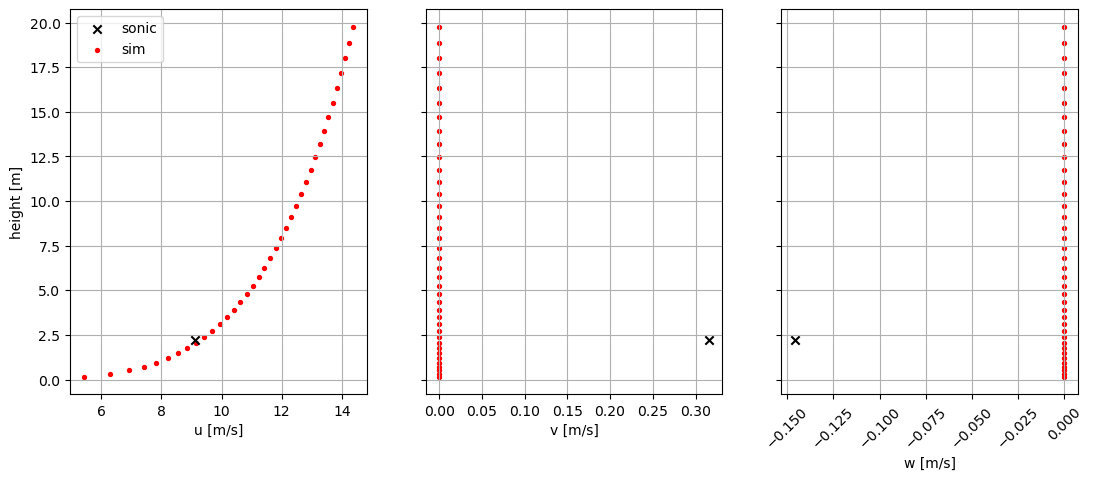

In [41]:
# mean profiles
y_idx = (np.abs(y_fp - 0.0)).argmin()

u_inp['sonic'] = sonic_data.filter(regex='u_', axis=1).values.squeeze()
u_inp['sim'] = sim_data['u'][:,:,y_idx]
v_inp['sonic'] = sonic_data.filter(regex='v_', axis=1).values.squeeze()
v_inp['sim'] = sim_data['v'][:,:,y_idx]
w_inp['sonic'] = sonic_data.filter(regex='w_', axis=1).values.squeeze()
w_inp['sim'] = sim_data['w'][:,:,y_idx]

fig, axs = plt.subplots(1,3, figsize=[13,5], sharey=True)
axs[0].scatter(u_inp['sonic'].mean(), heights[0], color='k', marker='x', label='sonic', zorder=100)
axs[0].scatter(u_inp['sim'].mean(axis=0), z_fp, color='r', s=8, label='sim')
# axs[0].scatter(m2_us, m2_zs, color='k', marker='x', label='M2 tower data')
axs[0].legend();
axs[0].set_xlabel('u [m/s]')
axs[0].set_ylabel('height [m]')
print('u_max = ',u_inp['sim'].mean(axis=0).max())

axs[1].scatter(v_inp['sonic'].mean(), heights[0], color='k', marker='x', label='sonic')
axs[1].scatter(v_inp['sim'].mean(axis=0), z_fp, color='r', s=8, label='sim')
axs[1].set_xlabel('v [m/s]')

axs[2].scatter(w_inp['sonic'].mean(), heights[0], color='k', marker='x', label='sonic')
axs[2].scatter(w_inp['sim'].mean(axis=0), z_fp, color='r', s=8, label='sim')
axs[2].set_xlabel('w [m/s]')
axs[2].tick_params(axis='x', rotation=45)

for ax in axs:
    # ax.set_xlim([0.05, 1.0])
    ax.grid()

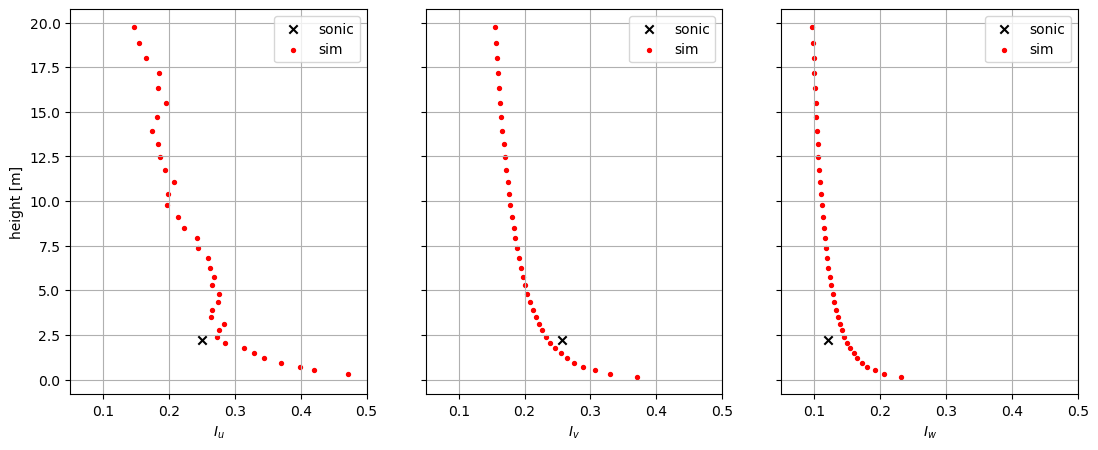

In [42]:
# TI profiles
def compute_TI(u,v,w):
    umag = (u**2 + v**2)**0.5
    
    Iu = np.std(u, axis=0) / np.mean(umag, axis=0)
    Iv = np.std(v, axis=0) / np.mean(umag, axis=0)
    Iw = np.std(w, axis=0) / np.mean(umag, axis=0)

    return Iu, Iv, Iw

y_idx = (np.abs(y_fp - 0.0)).argmin()

u_inp['sonic'] = sonic_data.filter(regex='u_', axis=1).values.squeeze()
u_inp['sim'] = sim_data['u'][:,:,y_idx]
v_inp['sonic'] = sonic_data.filter(regex='v_', axis=1).values.squeeze()
v_inp['sim'] = sim_data['v'][:,:,y_idx]
w_inp['sonic'] = sonic_data.filter(regex='w_', axis=1).values.squeeze()
w_inp['sim'] = sim_data['w'][:,:,y_idx]

Iu = {}; Iv = {}; Iw = {}
for var in vars:
    Iu[var], Iv[var], Iw[var] = compute_TI(u_inp[var], v_inp[var], w_inp[var])

fig, axs = plt.subplots(1,3, figsize=[13,5], sharey=True)
axs[0].scatter(Iu['sonic'], heights[0], color='k', marker='x', label='sonic', zorder = 100)
axs[0].scatter(Iu['sim'], z_fp, color='r', s=8, label='sim')
axs[0].legend();
axs[0].set_xlabel('$I_u$')
axs[0].set_ylabel('height [m]')

axs[1].scatter(Iv['sonic'], heights[0], color='k', marker='x', label='sonic', zorder = 100)
axs[1].scatter(Iv['sim'], z_fp, color='r', s=8, label='sim')
axs[1].legend();
axs[1].set_xlabel('$I_v$')

axs[2].scatter(Iw['sonic'], heights[0], color='k', marker='x', label='sonic', zorder = 100)
axs[2].scatter(Iw['sim'], z_fp, color='r', s=8, label='sim')
axs[2].legend();
axs[2].set_xlabel('$I_w$')

for ax in axs:
    ax.set_xlim([0.05, 0.5])
    ax.grid()


In [ ]:
# read in csv file if already generated
# sim_turb_df = pd.read_csv('constrained_turb_'+sonic_data_fn)
# sim_turb_df = pd.read_csv('constrained_turb_ny80_nz40_'+sonic_data_fn)

In [ ]:
# pyconturb's method - doesn't match up with mine

# # sanity check - should be similar
# # find the points close to where we want to look
# yloc, zloc = 0, 2.23  # location we want to compare
# isim = np.argmin((spat_df.loc['y'].values - yloc)**2+(spat_df.loc['z'].values - zloc)**2)
# icon = np.argmin((con_tc.loc['y'].values - yloc)**2+(con_tc.loc['z'].values - zloc)**2)

# # t, usim, ucon = sim_turb_df.index, sim_turb_df.iloc[:, isim], con_tc.get_time().iloc[:, icon]
# t = sim_turb_df.index
# usim = sim_turb_df.iloc[:, isim]
# ucon = con_tc.get_time().iloc[:, icon]
# # TODO ^ FIX THIS TO ONLY INCLUDE U

# # plot the time series
# # !!! TODO !!! PLOT U, V, W TIMESERIES
# plt.plot(t, usim, label='simulated', color='r')
# plt.plot(t, ucon, label='sonic', color='k')
# plt.axhline(sim_turb_df.iloc[:, isim].mean(), t[0], t[-1], linestyle='--', color='r')
# plt.axhline(con_tc.get_time().iloc[:, icon].mean(), t[0], t[-1], linestyle='--', color='k')
# plt.xlabel('time [s]')
# plt.ylabel('u [m/s]')
# plt.legend();

# measured_mean = con_tc.get_time().iloc[:, icon].mean()
# simulated_mean = sim_turb_df.iloc[:, isim].mean()
# print('measured mean wind speed = ', measured_mean)
# print('simulated mean wind speed = ', simulated_mean)
# print('percent error = {:.2f}%'.format(100*(simulated_mean - measured_mean) / measured_mean))

In [ ]:
# pyconturb's method - doesn't match up with mine

# stats = sim_turb_df.filter(regex='u_', axis=1).describe().loc[['mean', 'std']]
# # plot
# plt.clf(); plt.subplot(1, 2, 1);
# plt.scatter(stats.loc['mean'], spat_df.filter(regex='u_').loc['z'], color='r', label='Mean profile')
# plt.scatter(m2['u'], m2['z'], color='k', marker='x', label='M2 tower data')
# plt.scatter(con_tc.get_time().iloc[:, icon].mean(), 2.23, color='k', marker='o', label='Sonic 1')
# # plt.axhline(spat_df['u_p404'].z, stats.loc['mean'].min(), stats.loc['mean'].max(), linestyle='--', color='k')
# # plt.axhline(2.23, stats.loc['mean'].min(), stats.loc['mean'].max(), linestyle='--', color='r')
# plt.legend(loc='upper left')

# print('u_max = ',np.max(stats.loc['mean']))

# plt.subplot(1, 2, 2)
# plt.scatter(stats.loc['std'], spat_df.filter(regex='u_').loc['z'], color='r', label='Std dev')
# plt.legend();

In [ ]:
# plt.plot(sim_turb_df.u_p0, label='u')
# plt.plot(sim_turb_df.v_p0, label='v')
# plt.plot(sim_turb_df.w_p0, label='w')
# plt.ylabel('velocity [m/s]')
# plt.xlabel('time [s]')
# plt.legend()